In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = "/Users/fiodor/bsuir/MO/notMNIST_large"
pixel_depth = 255.0
max_images_count = 20000

train_dataset_size = 10000
test_dataset_size = 3800
validation_dataset_size = 2000

epochs = 50

### Инициализация датасетов

In [ ]:
def load_letter(folder, folder_name, max_images_cnt=None):
    image_files = os.listdir(folder)

    res_dataset = []

    images_cnt = 0
    for item in image_files:
        if images_cnt == max_images_cnt:
            break

        image_file = os.path.join(folder, item)
        try:
            image_data =  Image.open(image_file)
            res_dataset += [(folder_name, np.array(image_data).flatten())]
            images_cnt += 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    print(folder, "Loaded", len(res_dataset), "images")
    return res_dataset

def load_dataset(path, max_images_cnt=None):
    folders = os.listdir(path)

    max_images_per_folder = None
    if max_images_cnt is not None:
        max_images_per_folder = max_images_cnt // len(folders)
    res_dataset = []
    for folder in folders:
        cur_letter_dataset = load_letter(path + "/"  + folder, folder, max_images_per_folder)
        res_dataset += cur_letter_dataset

    return res_dataset

In [ ]:
dataset = load_dataset(dataset_path, max_images_count)

In [ ]:
import pandas as pd
frame = pd.DataFrame(data=dataset, columns=['labels', 'data'])
frame['raw_data'] = frame['data'].map(lambda x: np.array(x).tobytes())
frame['scaled'] = frame['data'].map(lambda x: np.array(x) / pixel_depth)

In [ ]:
grouped = frame.groupby('labels')
displayed = grouped.apply(lambda x: x[:1][['labels', 'data']])

plt.figure(figsize=(20,4))
for i, r in enumerate(displayed.itertuples(index=False)):
    (label, data) = r
    plt.subplot(2, 10, i + 1)
    plt.imshow(np.reshape(data, (28,28)), cmap=plt.cm.gray)
    plt.title(label, fontsize = 20)

In [ ]:
from collections import Counter

classes_cnt = len(Counter(frame.labels).keys())

train_size_per_class = int(train_dataset_size / classes_cnt)
test_size_per_class = int(test_dataset_size / classes_cnt)
validation_size_per_class = int(validation_dataset_size / classes_cnt)

train_dataset = grouped.apply(lambda x: x[:train_size_per_class])
test_dataset = grouped.apply(lambda x: x[train_size_per_class + validation_size_per_class:train_size_per_class + validation_size_per_class + test_size_per_class])
validation_dataset = grouped.apply(lambda x: x[train_size_per_class:train_size_per_class + validation_size_per_class])

train_dataset_distinct = train_dataset.drop_duplicates(subset=['labels', 'raw_data']).reset_index(drop=True)
test_dataset_distinct = test_dataset.drop_duplicates(subset=['labels', 'raw_data']).reset_index(drop=True)
validation_dataset_distinct = validation_dataset.drop_duplicates(subset=['labels', 'raw_data']).reset_index(drop=True)

print("Successfully dropped", len(train_dataset) - len(train_dataset_distinct), "duplicates from train dataset.")
print("Successfully dropped", len(test_dataset) - len(test_dataset_distinct), "duplicates from test dataset.")
print("Successfully dropped", len(validation_dataset) - len(validation_dataset_distinct), "duplicates from validation dataset.")

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

neurons_per_layer = [512, 512, 256, 128]
activation_funcs = [tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh]
optimizer = tf.optimizers.SGD()

### Простая модель
4 скрытых слоя

In [ ]:
model_primitive = keras.Sequential([
    keras.layers.Dense(neurons_per_layer[0], activation=activation_funcs[0]),
    keras.layers.Dense(neurons_per_layer[1], activation=activation_funcs[0]),
    keras.layers.Dense(neurons_per_layer[2], activation=activation_funcs[0]),
    keras.layers.Dense(neurons_per_layer[3], activation=activation_funcs[0]),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_primitive.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Модель с регуляризацией
4 скрытых слоя, регуляризация

In [ ]:
regularizer_rate = 1e-3
model_regularized = keras.Sequential([
    keras.layers.Dense(neurons_per_layer[0], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dense(neurons_per_layer[1], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dense(neurons_per_layer[2], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dense(neurons_per_layer[3], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_regularized.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Модель с дропаутами
4 скрытых слоя, регуляризация, 4 дропаута

In [ ]:
dropout_rate = 0.4
model_regularized_dropout = keras.Sequential([
    keras.layers.Dense(neurons_per_layer[0], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(neurons_per_layer[1], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(neurons_per_layer[2], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(neurons_per_layer[3], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_regularized_dropout.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Модель с динамическим рейтом

In [ ]:
train_images = [x.tolist() for x in train_dataset.scaled.values]
train_labels = [ord(x) - ord('A') for x in train_dataset.labels.values]
test_images = [x.tolist() for x in test_dataset.scaled.values]
test_labels = [ord(x) - ord('A') for x in test_dataset.labels.values]

In [ ]:
dropout_rate = 0.4
model_regularized_dynamic = keras.Sequential([
    keras.layers.Dense(neurons_per_layer[0], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(neurons_per_layer[1], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(neurons_per_layer[2], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(neurons_per_layer[3], activation=activation_funcs[0], kernel_regularizer=keras.regularizers.l2(regularizer_rate)),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_regularized_dynamic.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def train_model(model, epochs_count, train_data, train_target):
    history = model.fit(train_data, train_target, epochs=epochs_count)
    return model, history

In [ ]:
def test_model(model, test_data, test_target):
    test_loss, test_acc = model.evaluate(test_data, test_target)
    return test_acc, test_loss

In [ ]:
accuracies = []
losses = []
histories = []
for current_model in [model_primitive, model_regularized, model_regularized_dropout, model_regularized_dynamic]:
    trained, history = train_model(
        model=current_model,
        epochs_count=epochs,
        train_data=train_images,
        train_target=train_labels,
    )
    histories += [history]
    accuracy, loss = test_model(model=trained, test_data=test_images, test_target=test_labels)
    accuracies += [accuracy]
    losses += [loss]

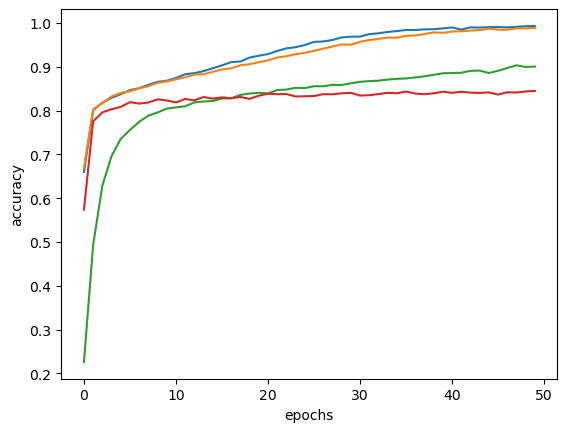

In [28]:
epochs_rate = [x for x in range(epochs)]
plt.plot(epochs_rate, histories[0].history['accuracy'])
plt.plot(epochs_rate, histories[1].history['accuracy'])
plt.plot(epochs_rate, histories[2].history['accuracy'])
plt.plot(epochs_rate, histories[3].history['accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

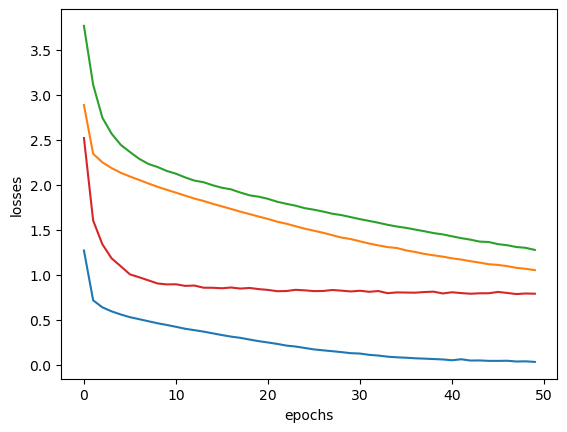

In [29]:
epochs_rate = [x for x in range(epochs)]
plt.plot(epochs_rate, histories[0].history['loss'])
plt.plot(epochs_rate, histories[1].history['loss'])
plt.plot(epochs_rate, histories[2].history['loss'])
plt.plot(epochs_rate, histories[3].history['loss'])
plt.xlabel("epochs")
plt.ylabel("losses")
plt.show()

In [30]:
validation_images = [x.tolist() for x in validation_dataset.scaled.values]
validation_labels = [ord(x) - ord('A') for x in validation_dataset.labels.values]

In [31]:
predictions = model_regularized_dynamic.predict(validation_images)

63/63 [==============================] - 0s 2ms/step


In [32]:
def plot_image(i, predictions_array, true_label, img, class_names):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(np.reshape(img, (28,28)), cmap=plt.cm.gray)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

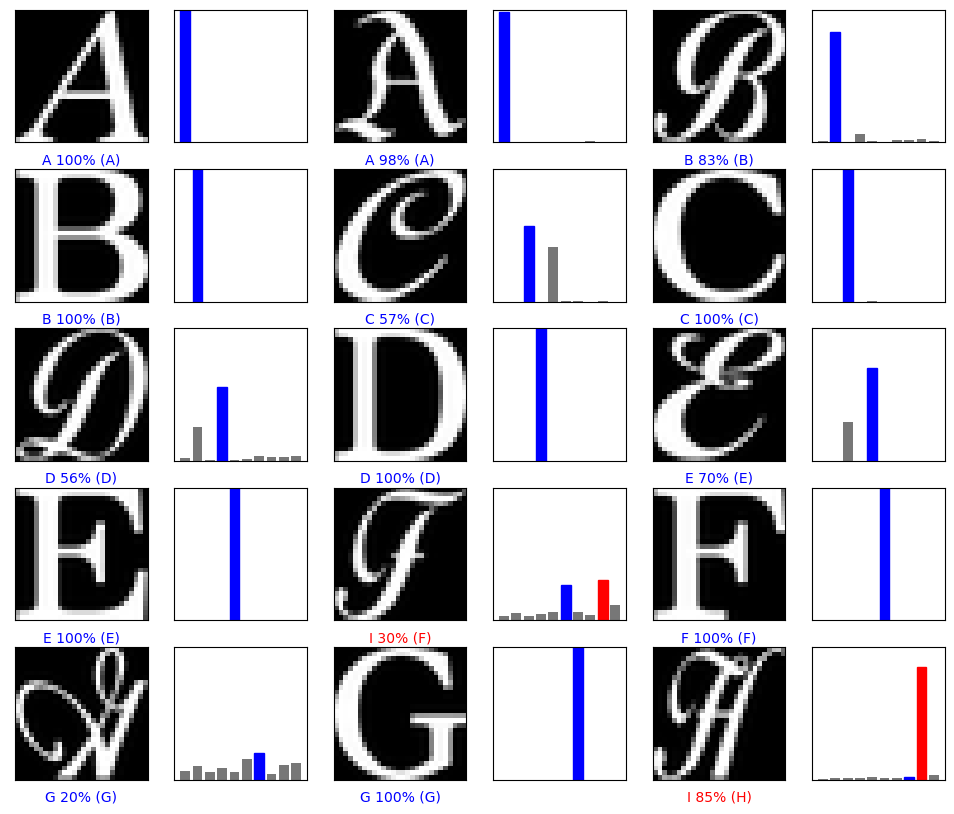

In [33]:
num_rows = 5
num_cols = 3
h = 100
keys = dict()
for label in validation_labels:
    keys[chr(label + ord('A'))] = True
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i * h, predictions, validation_labels, validation_dataset.scaled.values.tolist(), list(keys.keys()))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i * h, predictions, validation_labels)